In [3]:
import numpy as np
import pandas as pd
import glob
import string
import re
import nltk

from sklearn.feature_extraction.text import CountVectorizer 

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textwrap import wrap

# constants
stopwords = nltk.corpus.stopwords.words('english')

In [2]:
pip install WordCloud

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 363 kB 14.3 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [4]:
reviews_df = pd.read_csv('Reviews.csv')
print(reviews_df.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [5]:
reviews_df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [6]:
# number of null values per column
reviews_df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

# Preprocessing Dataframe and Text

In [7]:
# preprocessing for the dataframe 
def score(x):
    if x<3:
        return -1
    elif x==3 or x==4:
        return 0
    else:
        return 1

def preprocessing(df):
    # drop columns
    new_df = df.drop(columns = ["ProductId", "UserId", "ProfileName", "HelpfulnessNumerator", "HelpfulnessDenominator", "Time"])

    # drop na values
    new_df = new_df.dropna(axis=0)

    # make a new column of sentiment: (-1/0/1) -- pos/neutral/neg -- 1,2/3/4,5
    new_df['Sentiment'] = new_df.apply(lambda x: score(x['Score']), axis=1)


    return new_df

In [8]:
df = preprocessing(reviews_df)
df.head()

,Id,Score,Summary,Text,Sentiment
0,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1
2,3,4,"""Delight"" says it all",This is a confection that has been around a fe...,0
3,4,2,Cough Medicine,If you are looking for the secret ingredient i...,-1
4,5,5,Great taffy,Great taffy at a great price. There was a wid...,1


<BarContainer object of 3 artists>

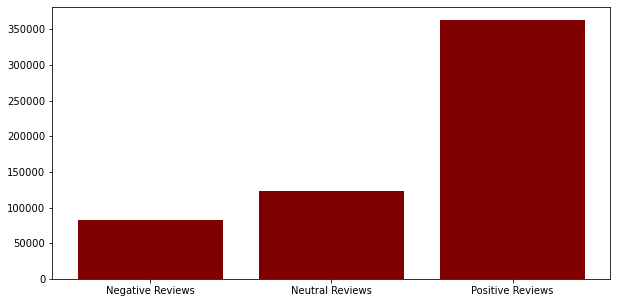

In [13]:
neg = len(df.loc[df['Sentiment'] == -1]['Text'])
neut = len(df.loc[df['Sentiment'] == 0]['Text'])
pos = len(df.loc[df['Sentiment'] == 1]['Text'])

h = ['Negative Reviews', 'Neutral Reviews', 'Positive Reviews']
vals = [neg,neut,pos]

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(h, vals, color ='maroon')

We can see our data is heavily skewed and we have a disportionate number of positive reviews. This may impact our model's ability to accurately predict negative review or neutral reviews. This in turn could lead to a higher true positive rate but also a higher false positive rate meaning we'd have a more sensitive and specific model.

Because our dataset is pretty big, we will run some of these cleaning methods on a smaller portion of the dataset. Some text cleaning:

In [14]:
def remove_stopwords(text):
    products = ['dog', 'food', 'soup', 'chai', 'tea','ordered','order','coconut','taffy','product']
    output= [i for i in text if i not in stopwords and i not in products]
    return output

In [32]:
test = df.iloc[:,0:10]
test["Clean Text"] = test["Text"].apply(lambda x: remove_stopwords(x))

In [ ]:
df["Clean Text"] = df["Text"].apply(lambda x: remove_stopwords(x))

Word clouds of different sentiment reviews:

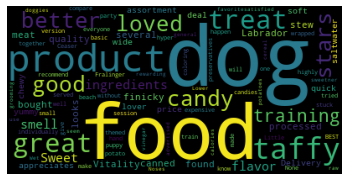

In [18]:
text = df.loc[df['Sentiment'] == 1]['Text'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

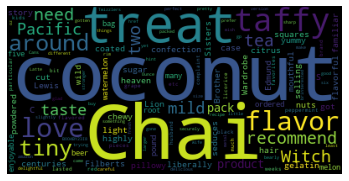

In [19]:
text = df.loc[df['Sentiment'] == 0]['Text'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

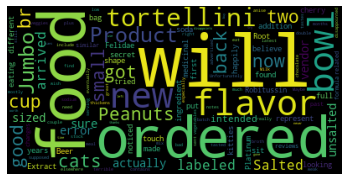

In [20]:
text = df.loc[df['Sentiment'] == -1]['Text'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

These wordclouds allow us to see frequent words in different sentiments. From these plots we can see another potential issue. Our model may start to associate neutral words with positive or negative sentiments. Because the products these reviews come from have a star rating and many of the reviews come from these same products, we are left with many reviews for the same product in the same sentiment category. Of course many of these reviews also mention the name of the product (i.e. dog food) and so these words become the most frequent in this sentiment category thus creating an issue for us. Unfortunately, dropping product names may be too tedious of a task so we have not yet decided how to proceed. 

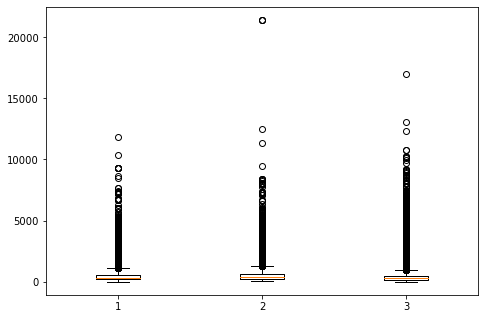

In [31]:
neg = []
neut = []
pos = []

for i in df.loc[df['Sentiment'] == 1]['Text'].values:
    pos.append(len(i))
    
for i in df.loc[df['Sentiment'] == 0]['Text'].values:
    neut.append(len(i))
    
for i in df.loc[df['Sentiment'] == -1]['Text'].values:
    neg.append(len(i))
    
neg = np.array(neg)
neut = np.array(neut)
pos = np.array(pos)

data = [neg, neut, pos]
 
fig = plt.figure()
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
 
# show plot
plt.show()

# Tokenization and Vectorization

Implementing Bag of Words strategy
Text preprocessing:
- Tokenization (breaking sentences into words)
- Stopwords (filtering "the", "are", etc)
- Occurrence counting (builds a dictionary of features from integer indices with word occurrences)
- Feature Vector (converts the dictionary of text documents into a feature vector)

In [40]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [41]:
#Split before hand but for now..

count_vect = CountVectorizer()

X_train = df['Text']
y_train = df['Sentiment']
X_train_counts = count_vect.fit_transform(X_train) 

In [36]:
X_train_counts.shape

(568427, 120252)

Here we have 568427 training samples and 12052 distinct words in our training sample.

Term Frequencies (Tf) divides number of occurrences for each word by total number of words
Term Frequencies times Inverse Document Frequency (Tfidf) downscales the weights of each word (assigns less value to unimportant stop words ie. "the", "are", etc)

In [39]:
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(568427, 120252)

In [43]:
#clf_multiNB_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), 
#                             ("clf_nominalNB", MultinomialNB())])
#clf_multiNB_pipe.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf_nominalNB', MultinomialNB())])